# LSTM Tutorial

In this notebook we will train a simple LSTM network in TensorFlow to classify digits from famous MNIST dataset (http://yann.lecun.com/exdb/mnist/).
The code is based on the work of Aymeric Damien (https://github.com/aymericdamien/TensorFlow-Examples).

There will be blanks left all over the code for the reader to fill out. If you ever get stuck, there's also a complete version in the repository.

Ready? **Let's go!**

Let's start by importing the needed packages.

In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

random.seed(1)
np.random.seed(1)
tf.set_random_seed(1)

## Download MNIST dataset

Fortunately, TensorFlow can download MNIST dataset for us automatically. It is also already divided into training, validation and test sets. We can also specify right away to transform the labels to one-hot form, which is needed for a softmax classifier. 

If you're not familiar with one-hot representation, read this great Quora answer (https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science). 


The process may take a while.

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Check training and test set

It is always a good idea to check the data we work with.

#### Number of train/test examples

Let's start with checking the number of examples we have available, both in training and test sets (we will not be using validation set in this tutorial). To do this, explore the ```mnist``` object.

(If you're not familiar with jupyter notebooks, you can do this by typing ```mnist.``` and pressing **Tab** to see the member fields and methods. Good luck!)

In [3]:
### [TASK] Get number of train/text examples
train_num_examples = mnist.train.num_examples
test_num_examples = mnist.test.num_examples
###
print('Number of train examples: {0}'.format(train_num_examples))
print('Number of train examples: {0}'.format(test_num_examples))

Number of train examples: 55000
Number of train examples: 10000


If you did this correctly, you should get the values as below:

Name | Value
--- | --- |
| Number of train examples     | 55000 |
| Number of test examples      | 10000 |

#### Image shape

So we know how many samples we have, but what about a single image?

Let's start by getting a single example and checking its shape. It doesn't matter if it comes from train or test set.

In [4]:
### [TASK] Get a random example from MNIST dataset
mnist_example = mnist.train.images[10]
###

print('Single example shape: {0}'.format(mnist_example.shape))

Single example shape: (784,)


Name | Value
--- | --- |
| Single example shape     | (784,) |

#### Vector to matrix

As you can see, the image is in a vector form. It's a common practice to reshape images to this form, since it's easier to process them like this on a computer.

That being said, we'd like to see what it looks like and for this we need to get the image to its original form. We have to use the knowledge of the MNIST dataset to achieve this: each digit is a square, black-and-white image (1 channel, not 3 as with normal images).

With that knowledge in mind, lets use the reshape function to change ```mnist_example``` to a square matrix form.

In [5]:
### [TASK] Reshape mnist_example to square matrix.
mnist_example = np.reshape(mnist_example, (28, 28))
###

print('MNIST digit shape: {0}'.format(mnist_example.shape))

MNIST digit shape: (28, 28)


Name | Value
--- | --- |
| MNIST digit shape     | (28, 28) |

#### Show a random MNIST training image

Now that we know how to restore digits to the original form, let's write a simple function to sample a random example from training set and show it using matplotlib. Your job is to retrive a correct label for the randomly chosen image (watch out for a one-hot vector!).

Correct label for image #7390: 7


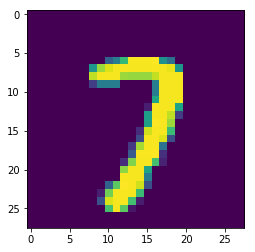

In [6]:
def show_random_mnist_train_example(mnist):
    """Draws a random training image from MNIST dataset and displays it.
    
    Args:
        mnist: MNIST dataset.
    """
    random_idx = random.randint(0, mnist.train.num_examples)
    image = mnist.train.images[random_idx].reshape(28, 28)
    imgplot = plt.imshow(image)
    ### [TASK] Get a correct label for the image 
    label = np.where(mnist.train.labels[random_idx] == 1)[0][0]
    ###
    print('Correct label for image #{0}: {1}'.format(random_idx, label))

show_random_mnist_train_example(mnist)

Name | Value
--- | --- |
| Correct label     | 7 |

## Model

We will be using a simple LSTM network with `timesteps` inputs of size `num_input` (slices of image, see preprocessing). The output of a final unrolled cell will be then fed through a simple linear layer to get a required number of outputs (`num_classes` = 10 for MNIST). Finally we will use a softmax cross-entropy loss to fit our model.

### Preprocessing

Since RNN requires a sequence of inputs and we have only one input (image), we have to divide the image into smaller parts. We will do this by moving a small window of arbitrary size (kernel) through the image. For each position of the kernel, we take the corresponding patch of the image, reshape it to vector (for training ease) and append in to the list of kernels.

We define 2 functions to do this:<br>
    1) **get_kernels** - retrieves all patches from image using a kernel of shape `kernel_shape`, which is moved by `stride` pixels in x and y direction at each step; if a kernel is partially outside of the image, zero-padding is used <br>
    2) **get_batch_kernels** - does the same as get_kernels, but for the batch of vector-shaped images
    
Your task is to write get_batch_kernels function, using get_kernels.

In [7]:
def get_patches(image, kernel_shape, stride):
    """Get all patches from image using a moving kernel.
    
    Args:
        image (matrix): Matrix of arbitrary shape.
        kernel_shape (tuple): The shape of the kernel.
        stride (tuple): Number of units to move the kernel in x and y.
        
    Returns:
        np.array: Array of vector-shaped patches.
    """
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel_shape
    stride_h, stride_w = stride
    h = w = 0
    patches = []
    while h < image_h:
        w = 0
        while w < image_w:
            patch = image[h : (h + kernel_h), w : (w + kernel_w)]
            if patch.shape != (kernel_h, kernel_w):
                # use zero padding
                patch = np.pad(patch, ((0, kernel_h - patch.shape[0]), 
                                         (0, kernel_w - patch.shape[1])), 'constant')
            patches.append(patch.reshape(-1))
            w += stride_w
        h += stride_h
    return np.array(patches)

def get_batch_patches(batch, kernel_shape, stride, image_shape=(28, 28)):
    """Gets patches from a batch of images.
    
    Args:
        batch (matrix): Matrix of images, shape [batch_size, image_vector_size].
        kernel_shape (tuple): The shape of the kernel.
        stride (tuple): Number of units to move the kernel in x and y.
        image_shape (tuple): Shape of a single image in matrix form.
    
    Returns:
        np.array: Array of patches from the batch.
    """
    batch_out = []
    ### [TASK] Retrieve patches for every image in batch:
    for image in batch:
        batch_out.append(get_patches(image.reshape(image_shape), kernel_shape, stride))
    ###
    return np.array(batch_out)


patches = get_batch_patches(mnist.train.images[:128], kernel_shape=[4, 4], stride=[4, 4])
print('Number of patches: {0}'.format(len(patches)))
print('Patches shape: {0}'.format(patches.shape))

Number of patches: 128
Patches shape: (128, 49, 16)


Name | Value
--- | --- |
| Number of patches     | 128 |
| Patches shape     | (128, 49, 16) |

For the purpose of this notebook, we will use patches of shape (1, 28). In other words, we will divide each image into rows, receiving 28 timesteps, each having 28 elements vector as an input. Run cell below to calculate the number of timesteps and input size. 

After finishing this notebook you should also try playing around with these parameters to find an optimal kernel shape and stride.

In [8]:
kernel_shape = (28, 1)
stride = (28, 1)
timesteps, num_input = get_patches(mnist.train.images[0].reshape(28, 28), kernel_shape, stride).shape
print('Timesteps: {0}'.format(timesteps))
print('Input vector size: {0}'.format(num_input))

Timesteps: 28
Input vector size: 28


Name | Value
--- | --- |
| Timesteps     | 28 |
| Input vector size     | 28 |

#### Config
It is often a good idea to put all configurable parameters in one dictionary. Run cell below to do this.

In [9]:
config = {'num_input': num_input, 'timesteps': timesteps, 'kernel_shape': kernel_shape, 'stride': stride,
          'num_hidden': 128, 'num_classes': 10, 'learning_rate': 0.001, 'training_steps': 10000, 
          'batch_size': 128, 'display_step': 200}

### Model class

Let's create a class representing our model. It is able to do the following:<br>
    1) Perform forward propagation. <br>
    2) Compute loss. <br>
    3) Minimize loss function (train). <br>
    4) Calculate accuracy. <br>
   
Note: Methods where moved outside of the class, for the ease of testing them. Normally, they would be inside the class.

In [10]:
class MnistLstmModel(object):
    def __init__(self, config):
        # Retrieve config parameters
        self._config = config
        timesteps, num_input, num_hidden = config['timesteps'], config['num_input'], config['num_hidden']
        num_classes, learning_rate = config['num_classes'], config['learning_rate']
        
        self.X, self.Y = get_placeholders(timesteps, num_input, num_classes)
        self.logits = forward_propagation(self.X, timesteps, num_hidden, num_classes)
        self.loss = compute_loss(self.logits, self.Y)
        self.train_op = optimize(self.loss, learning_rate)
        self.accuracy, _ = predict(self.logits, self.Y)

#### Create placeholders

Before we do anything, we must provide space for the input features and output labels. That is, tensorflow must know before computation begins, what the shape of input and output is, to allocate enough space. We can do this using tf.placeholders:
```python
    p = tf.placeholder(type, shape)
```
where type is usually set to ```tf.float32``` and shape is a list specyfing the final shape. Please note that the model will be given a batch of images at each iteration, not 1 or all of them. We do this by adding a ```None``` value to ```shape``` at the first position, e.g. for a single input of shape ```[a, b]```, batch input placeholder will be of shape ```[None, a, b]```.

Please create placeholders for X and Y of MNIST dataset (type: float).

In [11]:
def get_placeholders(timesteps, num_input, num_classes):
    ### [TASK] Create placeholders for input and output of MNIST dataset
    x = tf.placeholder(tf.float32, [None, timesteps, num_input])
    y = tf.placeholder(tf.float32, [None, num_classes])
    ###
    return x, y

In [12]:
tf.reset_default_graph()
X, Y = get_placeholders(config['timesteps'], config['num_input'], config['num_classes'])
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 28, 28), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


Name | Value
--- | --- |
| X | Tensor("Placeholder:0", shape=(?, 28, 28), dtype=float32) |
| Y | Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32) |

#### Forward propagation

Forward pass consists of 2 steps: <br>
1) LSTM forward pass. <br>
2) Linear layer forward pass, converting LSTM output to ```num_classes``` vector for loss computation. Only the last output is taken into consideration.

In [13]:
def forward_propagation(x, timesteps, num_hidden, num_classes):
    """Forward pass."""
    outputs, states = get_lstm(x, timesteps, num_hidden)
    logits = get_linear_layer(X=outputs[-1], num_in=num_hidden, num_out=num_classes)
    return logits

#### LSTM

Let's start with the LSTM part. We have to create a multi layer LSTM cell. You can do this in TF in 2 steps. <br>
1) Get a list of cells. Cell in this context is a single LSTM layer. To do this use ```tf.contrib.rnn.BasicLSTMCell```. <br>
2) Use the list of cells to create ```tf.contrib.MultiRNNCell```, which basically assembles cells into a single model. <br>

Afterwards, we use ```tf.contrib.rnn.static_rnn``` to connect our LSTM model with input.

Note: ```tf.contrib.rnn.static_rnn``` requires input to be in time-major form, i.e. instead of a tensor of shape ```[batch_size, timesteps, num_input]```, we have to get _timesteps_ number of tensors of shape ```[batch_size, num_input]```. We can do this by using ```tf.unstack```.

In [14]:
def get_lstm(x, timesteps, num_hidden, num_layers=1):
    cells = []
    for _ in range(num_layers):
        ### [TASK] Append a basic LSTM cell.
        cells.append(tf.contrib.rnn.BasicLSTMCell(num_hidden))
        ###
    ### [TASK] Construct a multi RNN cell.
    lstm_cell = tf.contrib.rnn.MultiRNNCell(cells)
    ###
    
    ### [TASK] Unstack input x.
    x = tf.unstack(x, axis=1)
    ###
    
    ### [TASK] Create static RNN of cells.
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    ###
    return outputs, states

#### Linear layer

We need to convert outputs of last LSTM to a num_classes sized vector. To do this, we will create a linear layer of weights and biases. You can use ```tf.get_variable``` to create weights and bias tensors, specifying shape and initializer. For this example, please use ```tf.random_normal_initializer(seed=1)``` (seed=1 to get the same results).

In [15]:
def get_linear_layer(X, num_in, num_out):
    ### [TASK] Create weights and bias variables and compute X*W + b
    W = tf.get_variable('weights_out', shape=[num_in, num_out], initializer=tf.random_normal_initializer(seed=1))
    b = tf.get_variable('bias_out', shape=[num_out], initializer=tf.random_normal_initializer(seed=1))
    output = tf.matmul(X, W) + b
    ###
    return output

#### Loss

Let's use ```tf.nn.softmax_cross_entropy_with_logits``` as our loss function. Please remember to return the mean value of the loss across the whole batch.

In [16]:
def compute_loss(logits, labels):
    ### [TASK] Calculate softmax cross-entropy loss (cost).
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ###
    return loss

#### Optimizer

Let's minimize our loss function with ```tf.train.GradientDescentOptimizer```.

In [17]:
def optimize(loss, learning_rate):
    return tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

#### Prediction

We want to know how well our model is performing in human-readable form. We will use a simple accuracy metric for this purpose: <br>
1) Calculate softmax with ```tf.nn.softmax``` <br>
2) Get a vector of correct predictions: if correct_pred[i] = 1, model predicted label correctly. Use ```tf.equal(labels, y_pred)``` to get the ```(labels == y_pred)``` element-wise and ```tf.argmax``` to find the model's predicted label. <br>
3) Get a mean value of above to calculate accuracy (you may need to convert tensorf to ```tf.float32``` first).

In [18]:
def predict(logits, labels):
    ### [TASK] Calcuate prediction accuracy
    y_pred = tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    ###
    return accuracy, correct_pred

## Training

Let's train our model and see how well it performs on MNIST dataset!

Step 1, Minibatch Loss= 3.1658, Training Accuracy= 0.133
Step 200, Minibatch Loss= 2.1227, Training Accuracy= 0.367
Step 400, Minibatch Loss= 1.9453, Training Accuracy= 0.523
Step 600, Minibatch Loss= 1.7082, Training Accuracy= 0.625
Step 800, Minibatch Loss= 1.3775, Training Accuracy= 0.641
Step 1000, Minibatch Loss= 1.1705, Training Accuracy= 0.750
Step 1200, Minibatch Loss= 1.2447, Training Accuracy= 0.680
Step 1400, Minibatch Loss= 1.1377, Training Accuracy= 0.695
Step 1600, Minibatch Loss= 1.0179, Training Accuracy= 0.750
Step 1800, Minibatch Loss= 0.9839, Training Accuracy= 0.734
Step 2000, Minibatch Loss= 0.8847, Training Accuracy= 0.766
Step 2200, Minibatch Loss= 1.0252, Training Accuracy= 0.742
Step 2400, Minibatch Loss= 0.8300, Training Accuracy= 0.734
Step 2600, Minibatch Loss= 0.9359, Training Accuracy= 0.750
Step 2800, Minibatch Loss= 0.8070, Training Accuracy= 0.781
Step 3000, Minibatch Loss= 0.8586, Training Accuracy= 0.742
Step 3200, Minibatch Loss= 0.8574, Training Acc

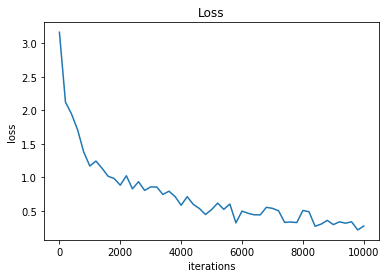

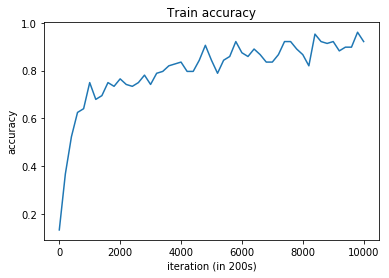

Testing Accuracy: 0.96875


In [19]:
tf.reset_default_graph()

tf.set_random_seed(1)
model = MnistLstmModel(config)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    losses, accs = [], []
    log_steps = []
    for step in range(1, config['training_steps'] + 1):
        batch_x, batch_y = mnist.train.next_batch(config['batch_size'])
        batch_x = get_batch_patches(batch_x, config['kernel_shape'], config['stride'])
        sess.run(model.train_op, feed_dict={model.X: batch_x, model.Y: batch_y})
        if step % config['display_step'] == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([model.loss, model.accuracy], feed_dict={model.X: batch_x,
                                                                          model.Y: batch_y})
            losses.append(loss)
            accs.append(acc)
            log_steps.append(step)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")
    
    # plot the cost
    plt.plot(log_steps, losses)
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.title('Loss')
    plt.show()
    
    # plot the cost
    plt.plot(log_steps, accs)
    plt.ylabel('accuracy')
    plt.xlabel('iteration (in 200s)')
    plt.title('Train accuracy')
    plt.show()

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = get_batch_patches(mnist.test.images[:test_len], config['kernel_shape'], config['stride'])
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
sess.run(model.accuracy, feed_dict={model.X: test_data, model.Y: test_label}))